In [1]:
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# Read csv file
Data = r'data/training.csv'
data = pd.read_csv(Data)

# Fill in missing value
data = data.fillna(0)

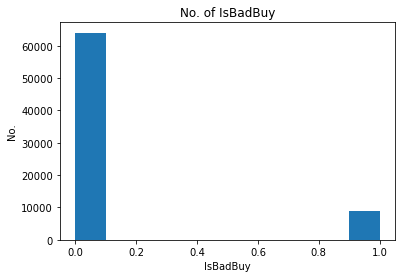

In [3]:
# Histogram of IsBadBuy column.
plt.hist(data['IsBadBuy'])

# title and label
plt.title('No. of IsBadBuy')
plt.xlabel('IsBadBuy')
plt.ylabel('No.')

# show
plt.show()

In [4]:
data.head(1)

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,0,0,21973,33619,FL,7100.0,0,1113


In [5]:
# Cleanning to avoid multicollinearity
dummy_WheelTypeID = pd.get_dummies(data['WheelTypeID'], prefix=['WheelTypeID'], drop_first=True)

data.drop('WheelTypeID', axis=1, inplace=True)

data = data.join(dummy_WheelTypeID)


In [6]:
data.head(5)

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,['WheelTypeID']_1.0,['WheelTypeID']_2.0,['WheelTypeID']_3.0
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,0,21973,33619,FL,7100.0,0,1113,1,0,0
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,0,19638,33619,FL,7600.0,0,1053,1,0,0
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,0,19638,33619,FL,4900.0,0,1389,0,1,0
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,0,19638,33619,FL,4100.0,0,630,1,0,0
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,0,19638,33619,FL,4000.0,0,1020,0,1,0


In [7]:
# Only includes the numerical features
data = data._get_numeric_data()

In [8]:
# shuffle data sequence in random
from sklearn.utils import shuffle
data_shf = shuffle(data)

# m: no. of samples
# n: no. of features
(m, n) = data_shf.shape

In [9]:
m, n

(72983, 21)

In [10]:
# Identify feature columns
fea_cols = data_shf.columns[2:]

X = data_shf[fea_cols]
Y = data_shf['IsBadBuy']

In [11]:
print (X.shape, Y.shape)

(72983, 19) (72983,)


In [12]:
# Normalizing feaures
from sklearn.preprocessing import StandardScaler
normalized_X = StandardScaler().fit_transform(X)

In [13]:
# folds for training and testing
folds = 5

In [14]:
# Slicing into training and testing set
ta_x = normalized_X[round(m/folds) + 1:]
ta_y = Y[round(m/folds) + 1:]

tt_x = normalized_X[:round(m/folds)]
tt_y = Y[:round(m/folds)]


In [15]:
print (ta_x.shape, ta_y.shape, tt_x.shape, tt_y.shape)

(58385, 19) (58385,) (14597, 19) (14597,)


In [22]:
# IsolationForest
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=500)

# Training
clf.fit(ta_x)

# Prediction
tt_pred_y = clf.predict(tt_x)
np.place(tt_pred_y, tt_pred_y==-1, 0)

# Performance measurement
print ('===== IsolationForest =====')
print ( '(Precision, Recall, fbeta_score, None): ', precision_recall_fscore_support(tt_y, tt_pred_y, average='binary'))

===== IsolationForest =====
(Precision, Recall, fbeta_score, None):  (0.11601369341955116, 0.8734249713631157, 0.20482170438519912, None)


In [24]:
# Logistic Regression and SVM
from sklearn import svm

In [18]:
## Logistic Regression
clf = svm.SVC()

# Linear Kernel
clf.set_params(kernel='linear').fit(ta_x, ta_y)

# Logistic Regression Prediction
tt_pred_y = clf.predict(tt_x)

# Performance measurement
print ('===== Logistic Regression =====')
print ( '(Precision, Recall, fbeta_score, None): ', precision_recall_fscore_support(tt_y, tt_pred_y, average='binary'))

===== Logistic Regression =====
(Precision, Recall, fbeta_score, None) :  (0.7102177554438861, 0.24256292906178489, 0.36162046908315565, None)


In [19]:
## SVM
clf = svm.SVC()

# RBF Kernel
clf.set_params(kernel='rbf').fit(ta_x, ta_y)

# SVM Prediction
tt_pred_y = clf.predict(tt_x)

# Performance measurement
print ('===== SVM =====')
print ( '(Precision, Recall, fbeta_score, None): ', precision_recall_fscore_support(tt_y, tt_pred_y, average='binary'))

===== SVM =====
(Precision, Recall, fbeta_score, None) :  (0.75227686703096541, 0.23627002288329518, 0.35959947757945143, None)


In [27]:
## Unsupervised SVM
clf = svm.OneClassSVM(kernel="rbf")
ta_x_regular = ta_x[ np.where(ta_y == 0)[0] ]
clf.fit(ta_x_regular)

# SVM Prediction

tt_pred_y = clf.predict(tt_x)

# Performance measurement
print ('===== Unsupervised SVM =====')
print ( '(Precision, Recall, fbeta_score, None): ', precision_recall_fscore_support(tt_y, tt_pred_y, average='binary'))

===== Unsupervised SVM =====
(Precision, Recall, fbeta_score, None):  (0.1099008518363357, 0.45074455899198168, 0.17671494330302009, None)


# Summary

## Procedure:
* read from csv file
* dealing with missing values
* excluding category features
* performing differenct models


## Conclusion 
We can see that in the fast testing result, based on the four model above, IsolationForest performance the best on recall 0.87, while SVM perform the best on precision 0.75. Since the problem wants to detect the anaomoly (around 1/7 of data), we need to find the few outliers. Thus, we care more about recall than precision. Therefore, IsolationForest performs well. I then try to include all the features given by the dataset. Please check the 'Analysis using all features.ipynb' for further computation.


